<a href="https://colab.research.google.com/github/comparativechrono/computational_biology_notebooks/blob/main/monte_carlo_worked_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


`Course:` **Mathematical & Computational Biology**  
`Module:` Simulation & Monte Carlo  
`Author:` Tim Hearn  
`License:` CC-BY-4.0



# Monte Carlo Simulation in Mathematical & Computational Biology - Worked Examples



## Introduction & learning goals

Monte Carlo (MC) simulation is a general approach for propagating randomness through mathematical models.  In computational biology, MC simulation allows us to explore how stochastic fluctuations and uncertain parameters influence system behaviour.  By drawing repeated random samples, we can approximate distributions of model outputs and assess variability.  This notebook contains three worked examples illustrating MC simulation for nested and multi-parameter models in mathematical and computational biology.

**Learning goals**

- Understand the rationale for MC simulation and its use in computational biology.
- Implement MC simulation for discrete stochastic processes (gene expression), deterministic models with uncertain parameters (enzyme kinetics) and nested population models.
- Analyse and visualise output distributions and trajectories.
- Interpret the biological meaning of the results and assess convergence.



## Prerequisites & package imports

Before running the examples, we import the necessary Python packages.  We rely only on open-source libraries available in a standard Anaconda distribution.  You should be comfortable with probability, basic calculus/differential equations, and programming in Python.

The random seed is set once to ensure reproducibility of simulations.


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import lognorm, norm, uniform

# Optional: seaborn for nicer plots (comment out if unavailable)
try:
    import seaborn as sns
    sns.set(style='whitegrid')
except ImportError:
    sns = None

# Set global random seed for reproducibility
np.random.seed(42)



## Example A - Stochastic gene expression (two-state promoter)

### Biological background

Gene expression is inherently stochastic because the underlying biochemical reactions involve small numbers of molecules.  Promoters can switch between transcriptionally **ON** and **OFF** states.  When the promoter is ON, RNA polymerase produces mRNA transcripts; when the promoter is OFF, no transcripts are produced.  Experimental studies demonstrate that this switching causes bursts of mRNA synthesis and cell-to-cell variability in protein levels (McAdams & Arkin, 1997; DOI: 10.1073/pnas.94.3.814).

### Mathematical model

The **two-state promoter** (telegraph) model assumes that the promoter can be in state $S \in \{0,1\}$, where 0 denotes the OFF state and 1 the ON state. Transitions between states occur as Poisson processes with rates:

- **Promoter activation (OFF → ON)** at rate $k_{\mathrm{on}}$.
- **Promoter deactivation (ON → OFF)** at rate $k_{\mathrm{off}}$.

When the promoter is ON, mRNA is synthesised at rate $k_{\mathrm{tx}}$. Each mRNA molecule degrades independently at rate $\gamma_m$. Let $m(t)$ denote the number of mRNA transcripts at time $t$. The reactions can be summarised as:


$$
S=0 \xrightarrow{k_{\mathrm{on}}} S=1, \qquad
S=1 \xrightarrow{k_{\mathrm{off}}} S=0
$$

$$
\text{ON} \xrightarrow{k_{\mathrm{tx}}} \text{ON} + \mathrm{mRNA}, \qquad
\mathrm{mRNA} \xrightarrow{\gamma_m} \varnothing
$$

The model contains four rate parameters $\theta = (k_{\mathrm{on}}, k_{\mathrm{off}}, k_{\mathrm{tx}}, \gamma_m)$. In this example we treat $k_{\mathrm{on}}$ and $k_{\mathrm{off}}$ as uncertain and draw them from log-normal distributions; the transcription and degradation rates are fixed.


### Parameter values and sampling

- $k_{\mathrm{on}}$: mean 0.01 s⁻¹ with log-normal standard deviation 0.5  
- $k_{\mathrm{off}}$: mean 0.1 s⁻¹ with log-normal standard deviation 0.3  
- $k_{\mathrm{tx}}$: 5.0 mRNA·s⁻¹ (fixed)  
- $\gamma_m$: 0.2 s⁻¹ (fixed)  
- Simulation horizon $T$: 100 time units


We perform Monte Carlo simulation by sampling $k_{\mathrm{on}}$ and $k_{\mathrm{off}}$ for each realisation. Each replicate simulates the stochastic process using the Gillespie algorithm and records the number of mRNA molecules at time $T$.


### Monte Carlo algorithm (pseudo-code)

1. **For** each replicate $i = 1, \ldots, N$:  
   1. Draw $k_{\mathrm{on},i} \sim \mathrm{LogNormal}(\mu_{\mathrm{on}}, \sigma_{\mathrm{on}})$ and $k_{\mathrm{off},i} \sim \mathrm{LogNormal}(\mu_{\mathrm{off}}, \sigma_{\mathrm{off}})$.  
   2. Initialise time $t \leftarrow 0$, promoter state $S \leftarrow 0$ (OFF), and mRNA count $m \leftarrow 0$.

3. **While** $t < T$:  
   - Compute propensities:  
     - $a_0 = k_{\mathrm{on},i}$ if $S = 0$ else $k_{\mathrm{off},i}$.  
     - $a_1 = k_{\mathrm{tx}}$ if $S = 1$ else 0.  
     - $a_2 = \gamma_m\, m$.  
   - Let $a = a_0 + a_1 + a_2$. If $a = 0$, break.  
   - Generate $r_1, r_2 \sim U(0,1)$.  
   - Increment time by $\Delta t = -\ln r_1 / a$ and set $t \leftarrow t + \Delta t$.  
   - Determine which reaction occurs:  
     - If $r_2 a < a_0$, switch promoter state (0 → 1 or 1 → 0).  
     - Else if $r_2 a < a_0 + a_1$, produce an mRNA ($m \leftarrow m + 1$).  
     - Else, degrade an mRNA ($m \leftarrow m - 1$).  
4. Record final mRNA count $m_i$. Optionally save trajectory $(t, m)$ for a subset of replicates.


### Simulation code

The following code implements the Gillespie simulation and performs 10,000 realisations.  We also store trajectories for the first 20 replicates to visualise temporal dynamics.


In [3]:

import math

# Helper function for the telegraph model using Gillespie algorithm
def simulate_telegraph(k_on, k_off, k_tx, gamma_m, T, return_trajectory=False):
    t = 0.0
    state = 0  # promoter state: 0 = OFF, 1 = ON
    m = 0      # mRNA count
    if return_trajectory:
        times = [t]
        counts = [m]
    while t < T:
        # Propensities
        a0 = k_on if state == 0 else k_off
        a1 = k_tx if state == 1 else 0.0
        a2 = gamma_m * m
        a_sum = a0 + a1 + a2
        if a_sum <= 0:
            break
        # Draw random numbers
        r1 = np.random.random()
        r2 = np.random.random()
        # Time to next reaction
        dt = -math.log(r1) / a_sum
        t += dt
        # Determine which reaction occurs
        if r2 * a_sum < a0:
            # Toggle promoter state
            state = 1 - state
        elif r2 * a_sum < a0 + a1:
            # Produce mRNA
            m += 1
        else:
            # Degrade mRNA if any
            if m > 0:
                m -= 1
        if return_trajectory:
            times.append(t)
            counts.append(m)
    if return_trajectory:
        return m, times, counts
    else:
        return m

# Parameters
N = 10000  # number of Monte Carlo realisations
T = 100.0  # simulation horizon
k_tx = 5.0
gamma_m = 0.2

# Log-normal distribution parameters for k_on and k_off
mu_on = math.log(0.01)  # mean of log
sigma_on = 0.5
mu_off = math.log(0.1)
sigma_off = 0.3

final_counts = np.empty(N, dtype=int)
trajectories = []

for i in range(N):
    # Sample rate constants from log-normal distributions
    k_on_i = np.random.lognormal(mean=mu_on, sigma=sigma_on)
    k_off_i = np.random.lognormal(mean=mu_off, sigma=sigma_off)
    if i < 20:
        m_final, times, counts = simulate_telegraph(k_on_i, k_off_i, k_tx, gamma_m, T, return_trajectory=True)
        trajectories.append((times, counts))
        final_counts[i] = m_final
    else:
        final_counts[i] = simulate_telegraph(k_on_i, k_off_i, k_tx, gamma_m, T)

# Convert first 20 trajectories into a DataFrame for plotting
traj_dfs = []
for idx, (times, counts) in enumerate(trajectories):
    traj_dfs.append(pd.DataFrame({'time': times, 'mRNA': counts, 'replicate': idx}))

traj_df = pd.concat(traj_dfs, ignore_index=True)

# Summary statistics
mean_m = final_counts.mean()
std_m = final_counts.std(ddof=1)
ci_lower, ci_upper = np.percentile(final_counts, [2.5, 97.5])

print(f"Mean final mRNA count: {mean_m:.2f} ± {std_m:.2f}")
print(f"95% CI for final mRNA count: [{ci_lower:.1f}, {ci_upper:.1f}]")


Mean final mRNA count: 2.45 ± 6.28
95% CI for final mRNA count: [0.0, 24.0]


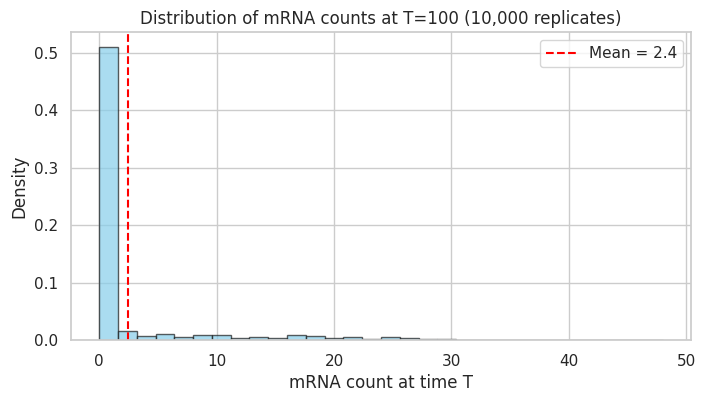

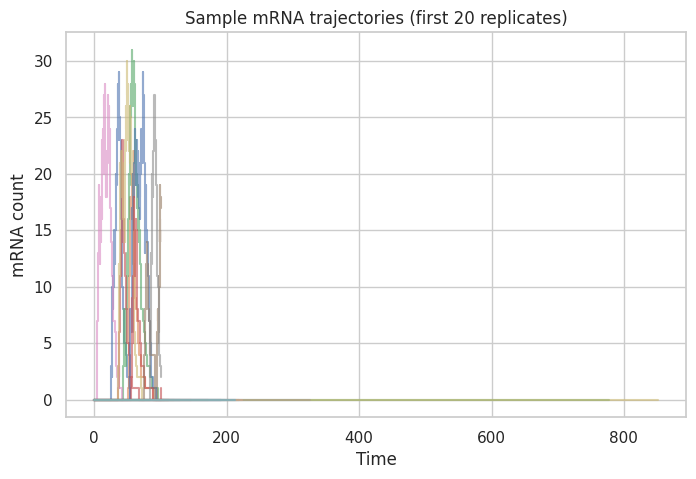

In [4]:

# Plot distribution of final mRNA counts
plt.figure(figsize=(8, 4))
plt.hist(final_counts, bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='k')
plt.xlabel('mRNA count at time T')
plt.ylabel('Density')
plt.title('Distribution of mRNA counts at T=100 (10,000 replicates)')
plt.axvline(mean_m, color='red', linestyle='dashed', label=f'Mean = {mean_m:.1f}')
plt.legend()
plt.show()

# Plot several example trajectories
plt.figure(figsize=(8, 5))
for idx in range(min(20, len(trajectories))):
    traj_subset = traj_df[traj_df['replicate'] == idx]
    plt.step(traj_subset['time'], traj_subset['mRNA'], where='post', alpha=0.6)
plt.xlabel('Time')
plt.ylabel('mRNA count')
plt.title('Sample mRNA trajectories (first 20 replicates)')
plt.show()



The histogram shows a broad distribution of mRNA counts at the final time. Even though all replicates share identical transcription ($k_{\mathrm{tx}}$) and degradation ($\gamma_m$) rates, variation in the promoter switching rates and stochastic reaction timing yields widely differing transcript numbers. Some realisations produce only a handful of transcripts whereas others exhibit dozens of bursts, leading to high counts. The sample trajectories illustrate bursty production: periods of zero transcription (promoter OFF) alternate with periods of rapid transcription (promoter ON), and the timing of switches differs between cells.

This example highlights how MC simulation can capture intrinsic noise in gene expression and how uncertain parameters propagate into output distributions. Extending the model to include translation, feedback, or multiple promoter states would follow the same simulation framework.


**Reference:** H. McAdams, & A. Arkin, (1997). Stochastic mechanisms in gene expression, Proc. Natl. Acad. Sci. U.S.A. 94 (3) 814-819, https://doi.org/10.1073/pnas.94.3.814



## Example B - Enzyme kinetics with competitive inhibition

### Biological background

Enzymes accelerate biochemical reactions by lowering activation energies. The Michaelis–Menten model describes how reaction velocity depends on substrate concentration. **Competitive inhibitors** bind to the active site and prevent substrate binding; they increase the apparent Michaelis constant ($K_m$) but do not change the maximal velocity ($V_{\max}$). Many pharmaceutical compounds act as competitive inhibitors to regulate metabolic pathways.

### Mathematical model

In the presence of a competitive inhibitor at concentration $[I]$, the reaction velocity $v$ follows the modified Michaelis–Menten equation:

$$
v = \frac{V_{\max}\,[S]}{K_m\,\bigl(1 + \frac{[I]}{K_i}\bigr) + [S]}.
$$

Here $[S]$ is the substrate concentration, $K_i$ is the inhibition constant (a smaller $K_i$ denotes stronger inhibition), and the bracketed terms denote concentrations. When the inhibitor is absent ($[I] = 0$), the equation reduces to the standard Michaelis–Menten form.


### Parameter values and uncertainty

We treat the kinetic parameters $V_{\max}$, $K_m$, and $K_i$ as uncertain and draw them from log-normal distributions. The substrate and inhibitor concentrations are fixed. Specifically:

- $[S]$ = 50 µM (constant)  
- $[I]$ = 30 µM (constant)  
- $V_{\max}$: mean 100 units·min⁻¹ with log-normal standard deviation 0.2  
- $K_m$: mean 10 µM with log-normal standard deviation 0.3  
- $K_i$: mean 15 µM with log-normal standard deviation 0.4  

Each Monte Carlo replicate samples $V_{\max}$, $K_m$, and $K_i$ and computes the reaction velocity. We also compute the uninhibited velocity $v_0$ (setting $[I] = 0$) to quantify the inhibitory effect.


### Monte Carlo algorithm (pseudo-code)

1. **For** each replicate $i = 1, \ldots, N$:  
   1. Draw $V_{\max,i}$, $K_{m,i}$, and $K_{i,i}$ from log-normal distributions with the specified means and standard deviations.  
   2. Compute the inhibited velocity  
      $$
      v_i = \frac{V_{\max,i}\,[S]}{K_{m,i}\,\bigl(1 + \frac{[I]}{K_{i,i}}\bigr) + [S]}.
      $$
   3. Compute the uninhibited velocity $v_{0,i} = \frac{V_{\max,i}\,[S]}{K_{m,i} + [S]}$.  
   4. Store $v_i$ and the ratio $v_i / v_{0,i}$.


### Simulation code

The following code performs 10 000 Monte Carlo samples and analyses the distribution of velocities.


In [5]:

# Parameters for the enzyme kinetics example
N_b = 10000
S_conc = 50.0  # substrate concentration (µM)
I_conc = 30.0  # inhibitor concentration (µM)

# Log-normal means and standard deviations
mu_V = math.log(100.0)  # mean of log for Vmax
sigma_V = 0.2
mu_Km = math.log(10.0)
sigma_Km = 0.3
mu_Ki = math.log(15.0)
sigma_Ki = 0.4

# Sample parameters
Vmax_samples = np.random.lognormal(mean=mu_V, sigma=sigma_V, size=N_b)
Km_samples = np.random.lognormal(mean=mu_Km, sigma=sigma_Km, size=N_b)
Ki_samples = np.random.lognormal(mean=mu_Ki, sigma=sigma_Ki, size=N_b)

# Compute velocities
v_samples = (Vmax_samples * S_conc) / (Km_samples * (1 + I_conc / Ki_samples) + S_conc)
v0_samples = (Vmax_samples * S_conc) / (Km_samples + S_conc)
ratio_samples = v_samples / v0_samples

# Summary statistics
mean_v = v_samples.mean()
std_v = v_samples.std(ddof=1)
ci_v = np.percentile(v_samples, [2.5, 97.5])

print(f"Mean inhibited velocity: {mean_v:.2f} ± {std_v:.2f}")
print(f"95% CI for inhibited velocity: [{ci_v[0]:.1f}, {ci_v[1]:.1f}]")


Mean inhibited velocity: 63.22 ± 15.95
95% CI for inhibited velocity: [36.5, 99.3]


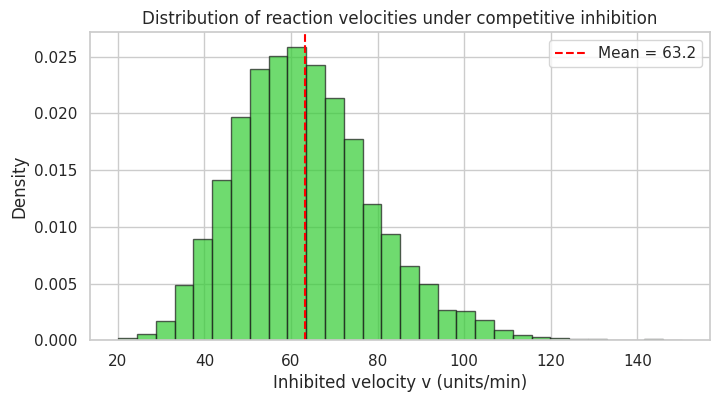

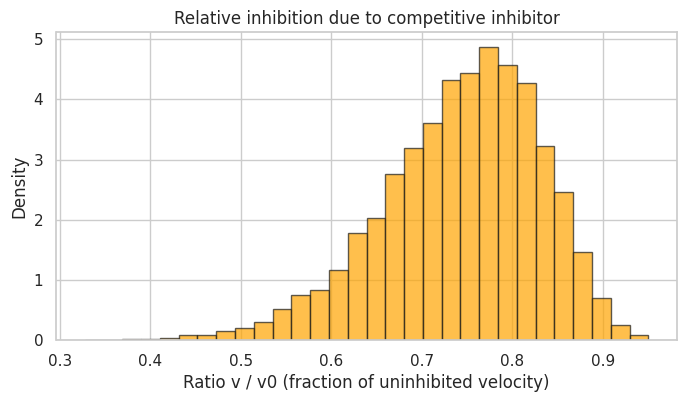

In [6]:

# Plot distribution of inhibited velocities
plt.figure(figsize=(8, 4))
plt.hist(v_samples, bins=30, density=True, alpha=0.7, color='limegreen', edgecolor='k')
plt.xlabel('Inhibited velocity v (units/min)')
plt.ylabel('Density')
plt.title('Distribution of reaction velocities under competitive inhibition')
plt.axvline(mean_v, color='red', linestyle='dashed', label=f'Mean = {mean_v:.1f}')
plt.legend()
plt.show()

# Plot distribution of inhibition ratio v/v0
plt.figure(figsize=(8, 4))
plt.hist(ratio_samples, bins=30, density=True, alpha=0.7, color='orange', edgecolor='k')
plt.xlabel('Ratio v / v0 (fraction of uninhibited velocity)')
plt.ylabel('Density')
plt.title('Relative inhibition due to competitive inhibitor')
plt.show()



The histogram of inhibited velocities shows a unimodal distribution centred below the mean of the uninhibited case. The spread arises from variability in $V_{\max}$, $K_m$, and $K_i$. Comparing the inhibited velocity $v$ to the uninhibited velocity $v_0$ reveals that the competitive inhibitor reduces the velocity to roughly 60-80 % of its uninhibited value for most parameter sets. Because a competitive inhibitor increases the apparent Michaelis constant without affecting $V_{\max}$, the degree of inhibition depends strongly on the relative magnitudes of $[I]$ and $K_i$.

This example illustrates how MC simulation propagates uncertainty in kinetic parameters to the distribution of enzyme velocities. Similar approaches can be used to model pharmacological variability or measurement error in enzyme assays.


**Reference:** Leskovac, V. (2003). *Comprehensive Enzyme Kinetics*. Springer. DOI: 10.1007/b100340.



## Example C - Population dynamics: logistic vs logistic + Allee (nested models)

### Biological background

Population growth models help ecologists and conservation biologists understand how populations change over time. The logistic growth model, introduced by Verhulst in 1838, accounts for limited resources by imposing a carrying capacity ($K$) beyond which populations cannot grow. The model is often written

$$
\frac{\mathrm{d}N}{\mathrm{d}t} = r N \left(1 - \frac{N}{K}\right),
$$

where $N(t)$ is the population size and $r$ the intrinsic growth rate. When $N \ll K$, growth is approximately exponential; as $N$ approaches $K$, growth slows and the population saturates. The logistic equation has been widely used across ecology, demography, and epidemiology (Bacaër, 2011; DOI: 10.1007/978-0-85729-115-8_6).

In some species, small populations experience a reduced per-capita growth rate because of mate limitation, social interactions, or cooperative behaviours. This phenomenon is known as the **Allee effect**. To incorporate Allee effects, the logistic equation can be extended to

$$
\frac{\mathrm{d}N}{\mathrm{d}t} = r N \left(1 - \frac{N}{K}\right)\left(\frac{N}{A} - 1\right),
$$

where $A > 0$ is the Allee threshold. When $N < A$, the term $(N/A - 1)$ is negative and the population declines; for $N > A$, the dynamics resemble logistic growth. The logistic model is nested within this family: it is recovered by setting $A \to 0$. Allee effects are important in invasion biology and conservation (Kanarek AR, Webb CT. doi: 10.1111/j.1752-4571.2009.00112.x.).


### Parameter distributions

We consider uncertain parameters and initial conditions to explore variability in population trajectories.  For each replicate we draw:

- Growth rate \(r\) from a log-normal distribution with mean 1.0 (time⁻¹) and standard deviation 0.2.
- Carrying capacity \(K\) from a normal distribution with mean 500 and standard deviation 50, truncated to ensure positivity.
- Allee threshold \(A\) from a normal distribution with mean 50 and standard deviation 10, truncated to be positive.  For the logistic model we set \(A=0\).
- Initial population \(N_0\) from a uniform distribution on [10, 100].

The simulation horizon is \(T = 20\) time units.  We compute the final population size for both models and examine the probability of extinction (\(N(T)\) below a small threshold).

### Monte Carlo algorithm (pseudo-code)

1. **Generate** arrays of $r_i$, $K_i$, $A_i$ (for the Allee model), and $N_{0,i}$ for $i = 1, \ldots, N$.  
2. **Logistic model:**  
   - Use the closed-form solution  
     $$
     N_i(T) = \frac{K_i}{1 + \left(\frac{K_i - N_{0,i}}{N_{0,i}}\right) \exp(-r_i T)}.
     $$
   - Record the final population size $N_i(T)$.  
3. **Logistic + Allee model:**  
   - Initialise $N_i \leftarrow N_{0,i}$ for each replicate.  
   - For time $t$ from 0 to $T$ in small steps $\Delta t$:  
     - Update each population using the Euler scheme  
       $$
       N_i \leftarrow N_i + r_i \, N_i \left(1 - \frac{N_i}{K_i}\right)\left(\frac{N_i}{A_i} - 1\right) \Delta t.
       $$
     - Enforce non-negativity of $N_i$ (set negative values to zero).  
   - Record $N_i(T)$.  
4. **Compute** summary statistics (means, confidence intervals) and the extinction probability (proportion of replicates with $N_i(T)$ below a threshold). Also record a handful of trajectories for visualisation.


### Simulation code

The code below performs 10,000 Monte Carlo simulations for both the logistic and logistic+Allee models using vectorised operations.


In [7]:

# Parameters for population dynamics example
N_c = 10000
T_final = 20.0

dt = 0.02  # time step for Euler integration in the Allee model
num_steps = int(T_final / dt)

# Sample parameters
r_samples = np.random.lognormal(mean=math.log(1.0), sigma=0.2, size=N_c)
K_samples = np.maximum(1e-3, np.random.normal(loc=500.0, scale=50.0, size=N_c))
A_samples = np.maximum(1e-3, np.random.normal(loc=50.0, scale=10.0, size=N_c))
N0_samples = np.random.uniform(low=10.0, high=100.0, size=N_c)

# Logistic model final population (closed form)
N_logistic_final = K_samples / (1.0 + ((K_samples - N0_samples) / N0_samples) * np.exp(-r_samples * T_final))

# Logistic+Allee model simulation using Euler method
N_allee = N0_samples.copy()
# Record trajectories for a small number of replicates
num_traj = 5
traj_times = np.linspace(0, T_final, num_steps + 1)
traj_logistic = []
traj_allee = []
# Initialise arrays for the first few trajectories
N_logistic_traj = np.empty((num_traj, num_steps + 1))
N_allee_traj = np.empty((num_traj, num_steps + 1))
# Assign initial values
for idx in range(num_traj):
    N_logistic_traj[idx, 0] = N0_samples[idx]
    N_allee_traj[idx, 0] = N0_samples[idx]

# Time integration for Allee model
for step in range(num_steps):
    # Compute growth for all replicates
    growth = r_samples * N_allee * (1 - N_allee / K_samples) * (N_allee / A_samples - 1)
    N_allee += dt * growth
    # Ensure non-negative populations
    N_allee = np.maximum(N_allee, 0.0)
    # Store trajectories for the first few replicates
    if step < num_steps:
        for idx in range(num_traj):
            # Logistic trajectory (analytical solution)
            N_logistic_traj[idx, step + 1] = K_samples[idx] / (1.0 + ((K_samples[idx] - N0_samples[idx]) / N0_samples[idx]) * np.exp(-r_samples[idx] * traj_times[step + 1]))
            # Allee trajectory (Euler solution)
            N_allee_traj[idx, step + 1] = N_allee[idx]

# Final population in Allee model
N_allee_final = N_allee.copy()

# Summary statistics
mean_logistic = N_logistic_final.mean()
ci_logistic = np.percentile(N_logistic_final, [2.5, 97.5])
mean_allee = N_allee_final.mean()
ci_allee = np.percentile(N_allee_final, [2.5, 97.5])

# Extinction threshold (population considered extinct if below this value)
ext_threshold = 1.0
ext_prob_logistic = np.mean(N_logistic_final < ext_threshold)
ext_prob_allee = np.mean(N_allee_final < ext_threshold)

print(f"Logistic model: mean final population = {mean_logistic:.1f}, 95% CI = [{ci_logistic[0]:.1f}, {ci_logistic[1]:.1f}], extinction probability = {ext_prob_logistic:.3f}")
print(f"Allee model:    mean final population = {mean_allee:.1f}, 95% CI = [{ci_allee[0]:.1f}, {ci_allee[1]:.1f}], extinction probability = {ext_prob_allee:.3f}")


Logistic model: mean final population = 500.7, 95% CI = [402.6, 599.8], extinction probability = 0.000
Allee model:    mean final population = 275.8, 95% CI = [0.0, 586.3], extinction probability = 0.449


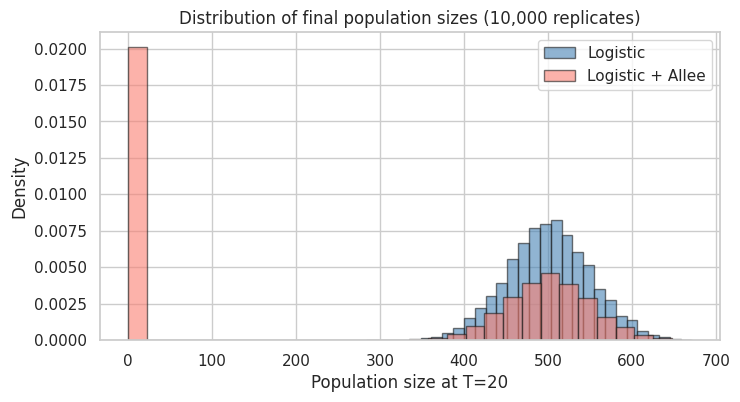

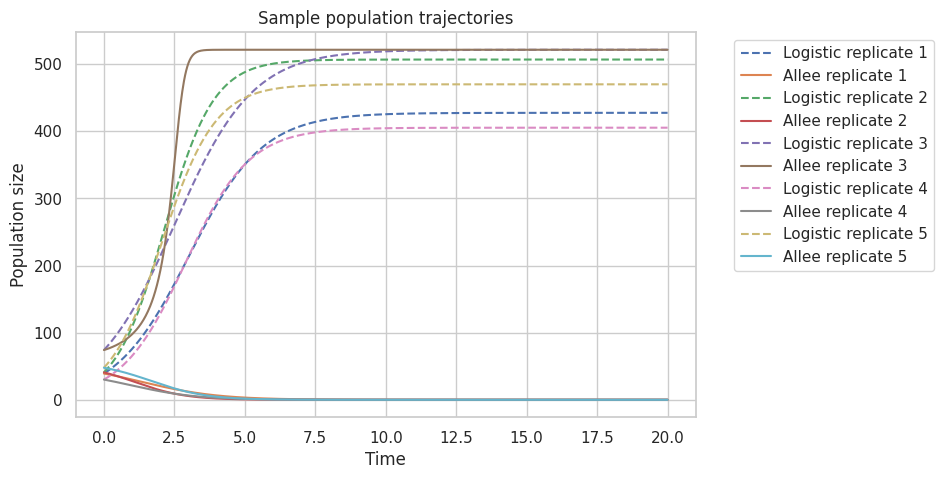

In [8]:

# Plot final population distributions
plt.figure(figsize=(8, 4))
plt.hist(N_logistic_final, bins=30, alpha=0.6, density=True, label='Logistic', color='steelblue', edgecolor='k')
plt.hist(N_allee_final, bins=30, alpha=0.6, density=True, label='Logistic + Allee', color='salmon', edgecolor='k')
plt.xlabel('Population size at T=20')
plt.ylabel('Density')
plt.title('Distribution of final population sizes (10,000 replicates)')
plt.legend()
plt.show()

# Plot a few sample trajectories
plt.figure(figsize=(8, 5))
for idx in range(5):
    plt.plot(traj_times, N_logistic_traj[idx], label=f'Logistic replicate {idx+1}', linestyle='--')
    plt.plot(traj_times, N_allee_traj[idx], label=f'Allee replicate {idx+1}')
plt.xlabel('Time')
plt.ylabel('Population size')
plt.title('Sample population trajectories')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()



The logistic model yields populations that asymptotically approach their carrying capacity.  Because the parameters \(r\) and \(K\) vary across replicates, the final populations form a wide distribution centred near the mean of \(K\).  Extinction (\(N(T) < 1\)) is extremely rare in the logistic model.

In contrast, the logistic+Allee model shows much greater variability.  Replicates with initial population \(N_0\) below the Allee threshold \(A\) decline toward zero and go extinct.  The extinction probability is markedly higher, and the distribution of surviving populations is skewed toward lower values.  Sample trajectories illustrate that populations must cross the Allee threshold before experiencing positive growth.

This example demonstrates how nested models (logistic vs logistic+Allee) can yield qualitatively different outcomes, and how MC simulation quantifies the risk of extinction under parameter uncertainty.

**References:**

- Bacaër, N. (2011). *Verhulst and the logistic equation (1838)*. In *A Short History of Mathematical Population Dynamics* (pp. 35-39). Springer. DOI: 10.1007/978-0-85729-115-8_6.
- Kanarek AR, Webb CT. Allee effects, adaptive evolution, and invasion success. Evol Appl. 2010 Mar;3(2):122-35. doi: 10.1111/j.1752-4571.2009.00112.x. PMID: 25567913; PMCID: PMC3352477.



## Key takeaways & further reading

- **Monte Carlo simulation** is a powerful tool for exploring stochastic dynamics and parameter uncertainty in biological models.  By generating many independent realisations, we approximate output distributions and quantify variability.
- **Intrinsic noise** in gene expression arises from random promoter switching and small molecule numbers.  The telegraph model captures bursty transcription and explains cell-to-cell variability.
- **Parameter uncertainty** in enzyme kinetics propagates to reaction velocities.  Sampling kinetic constants from plausible distributions reveals how competitive inhibitors reduce velocity and how variable parameters broaden the distribution.
- **Nested models** such as the logistic and logistic+Allee equations can exhibit qualitatively different behaviour.  The inclusion of an Allee effect introduces an extinction threshold and increases variability.
- **Convergence diagnostics** are important: increasing the number of simulations reduces Monte Carlo error.  For high-dimensional parameter spaces or stiff systems, variance-reduction or quasi-Monte-Carlo techniques may be beneficial.

**Further reading**

- Gillespie, D. T. (1977). *Exact stochastic simulation of coupled chemical reactions*. *The Journal of Physical Chemistry*, 81(25), 2340-2361. DOI: 10.1021/j100540a008.
- Wilkinson, D. J. (2006). *Stochastic Modelling for Systems Biology*. Chapman & Hall/CRC. ISBN: 978-1-58488-540-5.
- Tsoularis A, Wallace J. Analysis of logistic growth models. Math Biosci. 2002 Jul-Aug;179(1):21-55. doi: 10.1016/s0025-5564(02)00096-2. PMID: 12047920.
